# C964 - Task 02 - William Neyland
## Machine Learning Model

### Imports

In [26]:
# Imports Necessary Libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay
import ipywidgets as widgets
import datetime

# Removes future warning messages
import warnings
warnings.simplefilter(action='ignore')

### Data Wrangling

In [27]:
# Imports Data
data = "./index.csv"
df = pd.read_csv(data)

### Data Exploration

In [28]:
# Total Number of Columns and Rows in Data
print(f"Columns: {df.shape[1]:,}")
print(f"Rows: {df.shape[0]:,}")

Columns: 6
Rows: 1,395


In [29]:
# Shows Column Data Types
print(df.dtypes)

date            object
datetime        object
cash_type       object
card            object
money          float64
coffee_name     object
dtype: object


In [30]:
# Preview of First Five data rows
df.head(10)

,date,datetime,cash_type,card,money,coffee_name
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.7,Latte
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.7,Hot Chocolate
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.7,Hot Chocolate
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.9,Americano
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.7,Latte
5,2024-03-01,2024-03-01 15:39:47.726,card,ANON-0000-0000-0005,33.8,Americano with Milk
6,2024-03-01,2024-03-01 16:19:02.756,card,ANON-0000-0000-0006,38.7,Hot Chocolate
7,2024-03-01,2024-03-01 18:39:03.580,card,ANON-0000-0000-0007,33.8,Americano with Milk
8,2024-03-01,2024-03-01 19:22:01.762,card,ANON-0000-0000-0008,38.7,Cocoa
9,2024-03-01,2024-03-01 19:23:15.887,card,ANON-0000-0000-0008,33.8,Americano with Milk


### Data Visualizations -- Descriptive Methods

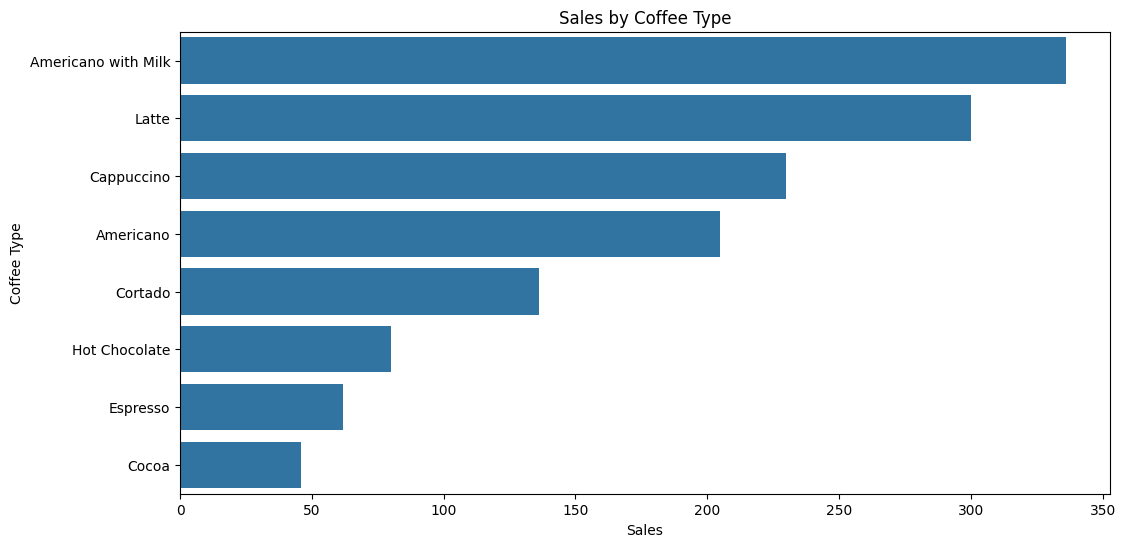

In [31]:
# Charts Sales by Coffee Types to determine most popular menu item

plt.figure(figsize=(12, 6))
sns.countplot(y='coffee_name', data=df, order=df['coffee_name'].value_counts().index)
plt.title('Sales by Coffee Type')
plt.xlabel('Sales')
plt.ylabel('Coffee Type')
plt.show()

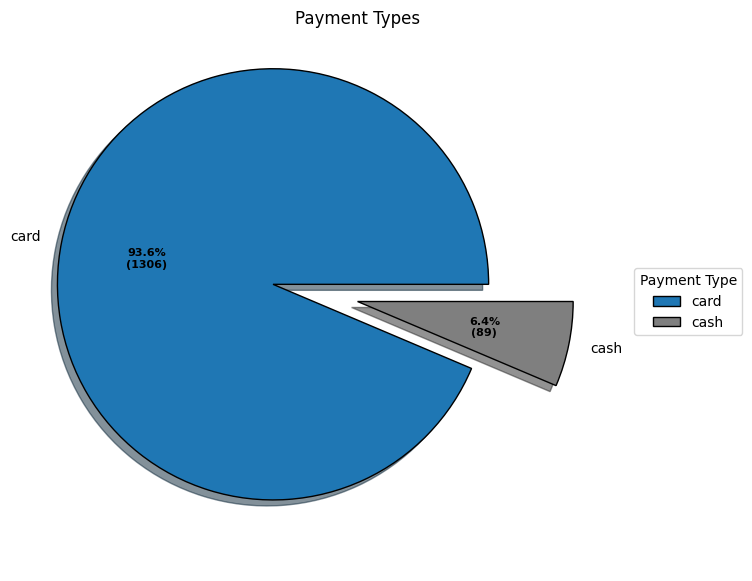

In [32]:
# Alternative View for Sales Distributed by Payment Type
card = (df.cash_type == "card").sum()
cash = (df.cash_type == "cash").sum()
data = [card, cash]
Labels = df['cash_type'].unique()

# Pie chart properties
explode = (0.4,0)
colors = ("tab:blue","tab:gray")
wp = {'linewidth':1, 'edgecolor': "black"}

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)

fig, ax = plt.subplots(figsize=(10,7))
wedges, texts, autotexts = ax.pie(data,
                                 autopct=lambda pct: func(pct, data),
                                 explode=explode,
                                 labels=Labels,
                                 shadow=True,
                                 colors=colors,
                                 startangle=0,
                                 wedgeprops=wp,
                                 textprops=dict(color='black'))

ax.legend(wedges, Labels, title='Payment Type', loc='center left', bbox_to_anchor=(1,0,0.5,1))
plt.setp(autotexts, size=8, weight='bold')
ax.set_title("Payment Types")
plt.show()

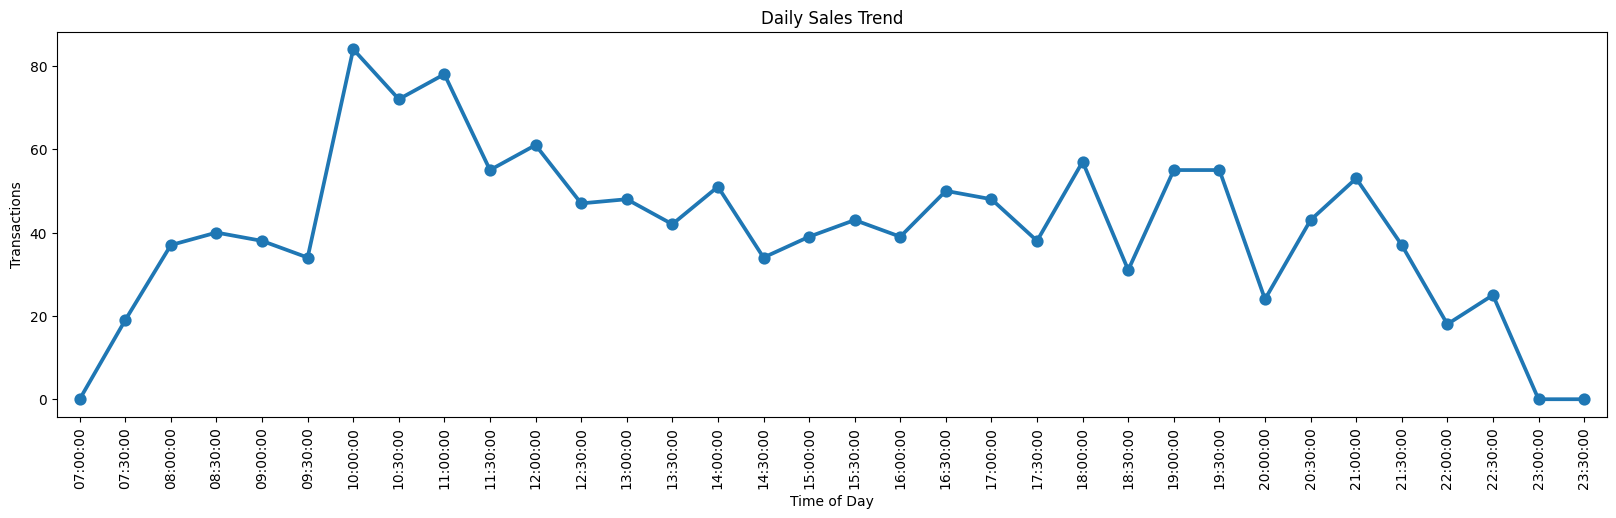

In [33]:
# Charts Sales trends for 30 minute intervals across a day of business
# Used to determine rush hours and down time in order to maximize schedule efficiency
df['datetime'] = pd.to_datetime(df['datetime'])
df['time'] = df['datetime'].dt.floor('30T').dt.time
df_by_hour = df.groupby("time").agg({"money": ["count"]}).reset_index()
df_by_hour.columns = ["time", "count"]

# Retrieves 30 Minute Time Intervals
all_intervals = pd.DataFrame(
    np.unique(pd.date_range(
        start=pd.to_datetime("2024-01-01 07:00:00").replace(second=0, microsecond=0), 
        end=pd.to_datetime("2024-01-01 23:30:00").replace(second=0, microsecond=0), 
        freq='30T'
    ).time), columns=['time']
)
df_by_hour = pd.merge(all_intervals, df_by_hour, on='time', how='left').fillna(0)

plt.figure(figsize=(20, 5))
sns.pointplot(df_by_hour, x="time", y="count")
plt.xticks(rotation=90)
plt.title('Daily Sales Trend')
plt.xlabel('Time of Day')
plt.ylabel('Transactions')
plt.show()

### Data Pre-Processing (Cleaning & Parsing)

In [34]:
# The Current Data Frame
df

,date,datetime,cash_type,card,money,coffee_name,time
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.70,Latte,10:00:00
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.70,Hot Chocolate,12:00:00
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.70,Hot Chocolate,12:00:00
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.90,Americano,13:30:00
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.70,Latte,13:30:00
...,...,...,...,...,...,...,...
1390,2024-08-27,2024-08-27 10:04:04.563,card,ANON-0000-0000-0375,32.82,Latte,10:00:00
1391,2024-08-28,2024-08-28 12:08:18.772,card,ANON-0000-0000-0551,27.92,Americano with Milk,12:00:00
1392,2024-08-28,2024-08-28 12:10:04.139,card,ANON-0000-0000-0551,32.82,Cappuccino,12:00:00
1393,2024-08-28,2024-08-28 12:35:06.944,card,ANON-0000-0000-0375,23.02,Americano,12:30:00


In [35]:
df.dtypes

date                   object
datetime       datetime64[ns]
cash_type              object
card                   object
money                 float64
coffee_name            object
time                   object
dtype: object

#### Extracting Necessary data from Datetime

In [36]:
# Extracting Month, Day, and Hour columns

df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['hour'] = pd.to_datetime(df['datetime']).dt.hour

In [37]:
# New Current Data Frame
df

,date,datetime,cash_type,card,money,coffee_name,time,month,day,hour
0,2024-03-01,2024-03-01 10:15:50.520,card,ANON-0000-0000-0001,38.70,Latte,10:00:00,3,1,10
1,2024-03-01,2024-03-01 12:19:22.539,card,ANON-0000-0000-0002,38.70,Hot Chocolate,12:00:00,3,1,12
2,2024-03-01,2024-03-01 12:20:18.089,card,ANON-0000-0000-0002,38.70,Hot Chocolate,12:00:00,3,1,12
3,2024-03-01,2024-03-01 13:46:33.006,card,ANON-0000-0000-0003,28.90,Americano,13:30:00,3,1,13
4,2024-03-01,2024-03-01 13:48:14.626,card,ANON-0000-0000-0004,38.70,Latte,13:30:00,3,1,13
...,...,...,...,...,...,...,...,...,...,...
1390,2024-08-27,2024-08-27 10:04:04.563,card,ANON-0000-0000-0375,32.82,Latte,10:00:00,8,27,10
1391,2024-08-28,2024-08-28 12:08:18.772,card,ANON-0000-0000-0551,27.92,Americano with Milk,12:00:00,8,28,12
1392,2024-08-28,2024-08-28 12:10:04.139,card,ANON-0000-0000-0551,32.82,Cappuccino,12:00:00,8,28,12
1393,2024-08-28,2024-08-28 12:35:06.944,card,ANON-0000-0000-0375,23.02,Americano,12:30:00,8,28,12


#### Removing Unecessary Columns

In [38]:
# Removing Unecessary Columns
df.drop(columns=['date','datetime','cash_type','card','money','time'],inplace=True)

In [39]:
# New Current Data Frame
df

,coffee_name,month,day,hour
0,Latte,3,1,10
1,Hot Chocolate,3,1,12
2,Hot Chocolate,3,1,12
3,Americano,3,1,13
4,Latte,3,1,13
...,...,...,...,...
1390,Latte,8,27,10
1391,Americano with Milk,8,28,12
1392,Cappuccino,8,28,12
1393,Americano,8,28,12


In [40]:
#Seperates independent from dependent variables for model Training
X = df.drop(columns=['coffee_name'])
y = df[['coffee_name']].copy()

# Provides a peek at the organization of the data used for training
print(X,y)
print(df.dtypes)

      month  day  hour
0         3    1    10
1         3    1    12
2         3    1    12
3         3    1    13
4         3    1    13
...     ...  ...   ...
1390      8   27    10
1391      8   28    12
1392      8   28    12
1393      8   28    12
1394      8   28    13

[1395 rows x 3 columns]               coffee_name
0                   Latte
1           Hot Chocolate
2           Hot Chocolate
3               Americano
4                   Latte
...                   ...
1390                Latte
1391  Americano with Milk
1392           Cappuccino
1393            Americano
1394  Americano with Milk

[1395 rows x 1 columns]
coffee_name    object
month           int32
day             int32
hour            int32
dtype: object


#### Create Train and Test Data Sets

In [41]:
# Creates Train and Test Data
X_train, X_test, y_train, y_test = model_selection.train_test_split(X,y, test_size=0.33, random_state=42)

### Model Training

#### Model 1: Support Vector Classifier Model

In [42]:
# Creates and Trains SVM Model
svm_model = svm.SVC(gamma='scale', C=1)
svm_model.fit(X_train, y_train)

SVC(C=1)

#### Model 2: Gaussian Naive Bayes

In [43]:
# Creates and trains Gaussian Naive Bayes Model
GNB_model = GaussianNB()
GNB_model.fit(X_train, y_train)

GaussianNB()

#### Model 3: Logistic Regression

In [44]:
# Creates and trains Logistic Regression Model
log_model = LogisticRegression(random_state=0)
log_model.fit(X_train, y_train)

LogisticRegression(random_state=0)

#### Model Comparisson

In [45]:
# Accuracy Prediction for Support Vector Classifier Model
SVM_predictions1 = svm_model.predict(X_train)
SVM_score1 = metrics.accuracy_score(y_train, SVM_predictions1)

SVM_predictions2 = svm_model.predict(X_test)
SVM_score2 = metrics.accuracy_score(y_test, SVM_predictions2)

print("SVM - Accuracy on training data: " + str(SVM_score1))
print("SVM - Accuracy on testing data: " + str(SVM_score2)+"\n")
###############################################################

# Accuracy Prediction for Gaussian Naive Bayes Model
GNB_predictions1 = GNB_model.predict(X_train)
GNB_score1 = metrics.accuracy_score(y_train, GNB_predictions1)

GNB_predictions2 = GNB_model.predict(X_test)
GNB_score2 = metrics.accuracy_score(y_test, GNB_predictions2)

print("GNB - Accuracy on training data: " + str(GNB_score1))
print("GNB - Accuracy on testing data: " + str(GNB_score2)+"\n")
################################################################

# Accuracy Prediction for Logistic Regression Model
LOG_predictions1 = log_model.predict(X_train)
LOG_score1 = metrics.accuracy_score(y_train, LOG_predictions1)

LOG_predictions2 = log_model.predict(X_test)
LOG_score2 = metrics.accuracy_score(y_test, LOG_predictions2)

print("LOG - Accuracy on training data: " + str(LOG_score1))
print("LOG - Accuracy on testing data: " + str(LOG_score2)+"\n")

SVM - Accuracy on training data: 0.27944325481798715
SVM - Accuracy on testing data: 0.2299349240780911

GNB - Accuracy on training data: 0.25374732334047106
GNB - Accuracy on testing data: 0.2386117136659436

LOG - Accuracy on training data: 0.26552462526766596
LOG - Accuracy on testing data: 0.23644251626898047



In [46]:
# Accuracy Prediction for Gaussian Naive Bayes Model
GNB_predictions1 = GNB_model.predict(X_train)
GNB_score1 = metrics.accuracy_score(y_train, GNB_predictions1)

GNB_predictions2 = GNB_model.predict(X_test)
GNB_score2 = metrics.accuracy_score(y_test, GNB_predictions2)

print("GNB - Accuracy on training data: " + str(GNB_score1))
print("GNB - Accuracy on testing data: " + str(GNB_score2)+"\n")

GNB - Accuracy on training data: 0.25374732334047106
GNB - Accuracy on testing data: 0.2386117136659436



#### Guassian Naive Bayes Model - Confusion Matrix

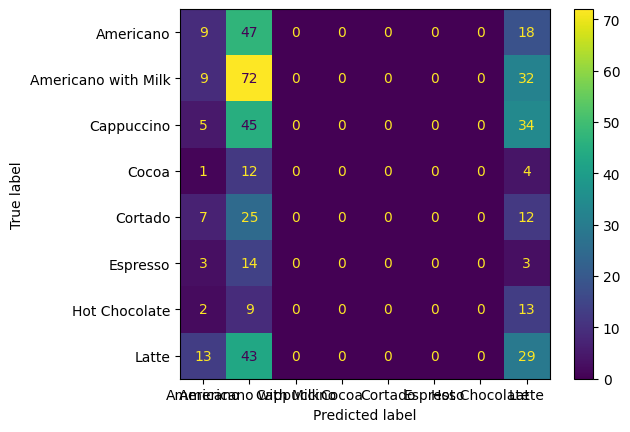

In [47]:
# Descriptive Method of Guassian Naive Bayes Model
# Display a confusion matrix showing the accuracy of the models predictions
Conf_Matrix = ConfusionMatrixDisplay.from_estimator(GNB_model, X_test, y_test)

# Creates a larger version of the confusion matrix -- Commented out for sake of display space
#fig, ax = plt.subplots(figsize=(15,15))
#Conf_Matrix.plot(ax=ax)

#### Example: A Full Day of Top Selling Drinks Every Hour

In [48]:
# Prints the most popular drink every hour for a full day
# Time Format [[Month,Day,Hour]]
# Example: [[3,13,10]] == March 13th, @ 10am

print(GNB_model.predict([[3,13,1]]))
print(GNB_model.predict([[3,13,2]]))
print(GNB_model.predict([[3,13,3]]))
print(GNB_model.predict([[3,13,4]]))
print(GNB_model.predict([[3,13,5]]))
print(GNB_model.predict([[3,13,6]]))
print(GNB_model.predict([[3,13,7]]))
print(GNB_model.predict([[3,13,8]]))
print(GNB_model.predict([[3,13,9]]))
print(GNB_model.predict([[3,13,10]]))
print(GNB_model.predict([[3,13,11]]))
print(GNB_model.predict([[3,13,12]]))
print(GNB_model.predict([[3,13,13]]))
print(GNB_model.predict([[3,13,14]]))
print(GNB_model.predict([[3,13,15]]))
print(GNB_model.predict([[3,13,16]]))
print(GNB_model.predict([[3,13,17]]))
print(GNB_model.predict([[3,13,18]]))
print(GNB_model.predict([[3,13,19]]))
print(GNB_model.predict([[3,13,20]]))
print(GNB_model.predict([[3,13,21]]))
print(GNB_model.predict([[3,13,22]]))
print(GNB_model.predict([[3,13,23]]))
print(GNB_model.predict([[3,13,24]]))

['Cortado']
['Cortado']
['Cortado']
['Cortado']
['Americano']
['Americano']
['Americano']
['Americano']
['Americano']
['Americano']
['Americano']
['Americano']
['Americano']
['Americano']
['Americano']
['Latte']
['Latte']
['Latte']
['Latte']
['Latte']
['Latte']
['Latte']
['Latte']
['Latte']


In [49]:
# Uses GNB Model

# Creates Input Widgets
month_widget = widgets.FloatText(description="Month: ", value="0")
day_widget = widgets.FloatText(description="Day: ", value="0")
hour_widget = widgets.FloatText(description="Hour: ", value="0")

# Create Button
button_predict = widgets.Button(description="Predict")
button_output = widgets.Label("Enter values and press the \"Predict\" button.")

# Button Behavior
def on_click_predict(b):
    predicition = GNB_model.predict([[
        month_widget.value, day_widget.value, hour_widget.value]])
    button_output.value='Top Selling Drink: '+ str(predicition[0])
button_predict.on_click(on_click_predict)

# Add Widgets to a view box and then display them
vb=widgets.VBox([month_widget, day_widget, hour_widget, button_predict, button_output])
print('\033[1m' + 'Enter values as whole numbers and make a prediction' + '\033[0m')
display(vb)

Enter values as whole numbers and make a prediction
